# cluster trajectory via AHC

In [19]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [44]:
base_path = '/sciclone/geograd/stmorse/reddit/mbkm_50'
months = ['03', '04', '05']

# open cluster centers
ccs = {}
for i in range(3):
    with open(f'{base_path}/models/model_cc_2011-{months[i]}.npz', 'rb') as f:
        ccs[i] = np.load(f)['cc']
C = np.vstack([ccs[i] for i in range(len(ccs))])
print(C.shape)

# open tfidf
tfidfs = {}
T = []
for i in range(3):
    with open(f'{base_path}/tfidf/tfidf_2011-{months[i]}.pkl', 'rb') as f:
        tfidfs[i] = pickle.load(f)
    # TODO: hacky, maybe 'tfidf' shouldn't be a dict
    for j in range(len(tfidfs[i]['tfidf'].keys())):
        T.append(tfidfs[i]['tfidf'][j]['keywords'])
print(len(T))

(150, 384)
150


(150, 384)


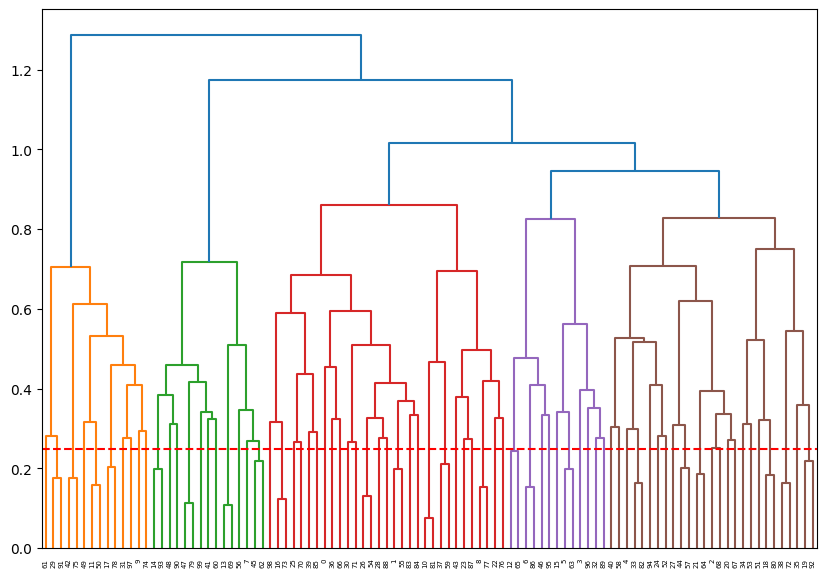

In [51]:
# cluster centroids
C = np.vstack([ccs[i] for i in range(len(ccs))])
print(C.shape)

# Perform hierarchical/agglomerative clustering
Z = linkage(C[:100], 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.axhline(y=0.25, color='r', linestyle='--')

plt.show()

In [52]:
ahc = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=0.25, 
    linkage='ward'
)

ahc.fit(C)
ahc.n_clusters_

94

In [49]:
k = 2
idx = np.where(ahc.labels_ == k)[0]
print(idx)
for x in idx:
    print(f'{x}: {T[x][:5]}')

[ 29  91 125]
29: ['government' 'tax' 'wealth' 'taxes' 'pay']
91: ['money' 'government' 'profits' 'billion' 'companies']
125: ['spending' 'cash' 'rich' 'spend' 'debt']


# Cluster trajectory testing

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# with open('/sciclone/geograd/stmorse/reddit/embeddings/embeddings_2009-03.npz', 'rb') as f:
#     embedding0 = np.load(f)

# with open('/sciclone/geograd/stmorse/reddit/embeddings/embeddings_2009-04.npz', 'rb') as f:
#     embedding1 = np.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/tfidf_mbkm_80/tfidf_2011-03.pkl', 'rb') as f:
    tfidf0 = pickle.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/tfidf_mbkm_80/tfidf_2011-04.pkl', 'rb') as f:
    tfidf1 = pickle.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/maps_mbkm_80/maps_2011-03.pkl', 'rb') as f:
    output = pickle.load(f)

In [3]:
tfidf0.keys(), output.keys()

(dict_keys(['year', 'month', 'full', 'tfidf']),
 dict_keys(['year', 'month', 'cluster_map', 'similarity']))

In [4]:
tfidf0['tfidf'][0].keys()

dict_keys(['sample_indices', 'keywords'])

In [6]:
n0 = len(tfidf0['tfidf'])

for i in range(5, 10):
    print(i)
    print(tfidf0['tfidf'][i]['keywords'])
    idx = np.where(output['similarity'][i] > 0)[0]
    for j in idx:
        print(f'  {j}: {output['similarity'][i,j]:.3f} -- {tfidf1['tfidf'][j]['keywords']}')

5
['king' 'aliens' 'marry' 'gases' 'scheherazade' 'virgins' 'blah' 'aladdin'
 'prints' 'belief' 'sleep' 'tale' 'visited' 'nights' 'greenhouse'
 'penthouse' 'altruism' 'talks' 'genes' 'color']
  10: 0.026 -- ['philosophy' 'fiber' 'yang' 'fountainhead' 'thompson' 'null' 'kan' 'int'
 'rand' 'objective' 'comcast' 'religion' 'blah' 'nervous' 'peta'
 'evolutionary' 'worry' 'proud' 'interdisciplinary' 'motors']
  19: 0.026 -- ['gene' 'therapy' 'dun' 'genes' 'cells' 'paste' 'sangamo' 'hiv' 'miter'
 'vortexoptics' 'pst' 'immune' 'optics' 'democracy' 'finger' 'albeit'
 'patients' 'vivo' 'cps' 'cancers']
  54: 0.026 -- ['doot' 'vcs' 'isp' 'vr' 'cc' 'files' 'truth' 'tank' 'blah'
 'libertarianism' 'norway' 'distance' 'draw' 'squirrels' 'fucksouthdakota'
 'hayek' 'dee' 'hdi' 'frogs' 'nsa']
  59: 0.053 -- ['greenhouse' 'plumber' 'gases' 'warming' 'global' 'navy' 'danger' 'pic'
 'cent' 'guitar' 'per' 'families' 'yokosuka' 'nitrous' 'methane'
 'capability' 'globe' 'machine' 'oxide' 'affected']
  61: 0.

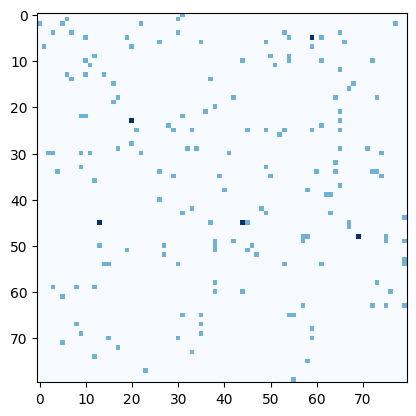

In [16]:
plt.imshow(output['similarity'], cmap='Blues', vmin=0, vmax=np.amax(output['similarity']))

# Bipartite graph test

In [3]:
import networkx as nx

In [6]:
G = nx.Graph()

n = 4

U = [f'u{i}' for i in range(n)]
V = [f'v{i}' for i in range(n)]
G.add_nodes_from(U, bipartite=0)
G.add_nodes_from(V, bipartite=1)

B = np.array([
    [0, 0.4, 0, 0.01],
    [0, 0.8, 0, 0.02],
    [0.9, 0, 0, 0],
    [0.1, 0, 0.1, 0.85]
])

threshold = 0.1

for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        if B[i,j] >= threshold:
            G.add_edge(U[i], V[j])

connected_components = list(nx.connected_components(G))

for i, component in enumerate(connected_components):
    print(f'{i}: {component}')

0: {'v1', 'u1', 'u0'}
1: {'u3', 'v3', 'v0', 'v2', 'u2'}
